In [83]:
# libraries needed to be installed:

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)

In [84]:
# wrangling

library(readxl)
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url, destfile = "processed.cleveland.data")

heart_data <- read.table("processed.cleveland.data", sep = ",") %>%
rename(
age = V1, # (years)
sex = V2, # 1 == male, 0 == female
chest_pain_type = V3, # 1 == typical angina, 2 == atypical angina, 3 == non-anginal pain, 4 == asymptomatic
resting_blood_pressure = V4, # (mmHg)
cholesterol_level = V5, # (mg/dl)
fasting_blood_sugar = V6, # 1 == higher than 120 mg/dl, 0 == not higher than 120 mg/dl
resting_electrocardiographic_results = V7, # 0 == normal, 1 == ST-T wave abnormality, 2 == probable or definite left ventricular hypertrophy
maximum_heart_rate_achieved = V8, # (bpm?) *unit not stated
exercise_induced_angina = V9, # 1 == yes, 0 == no
excercise_induced_ST_depression = V10, # *unit not stated
slope = V11, # slope of the peak exercise ST segment. 1 == upsloping, 2 == flat, 3 == downsloping
major_vessels_coloured = V12, # number of major vessels (0-3) colored by flourosopy
thal = V13, # 3 == normal, 6 == fixed defect, 7 == reversable defect
diagnosis = V14) %>% # 0 == no heart disease, 1 to 4 == heart disease, with different levels of severity (4 is most severe)

na.omit(age, resting_blood_pressure, cholesterol_level) %>%
select(age, resting_blood_pressure, cholesterol_level, diagnosis) %>%
mutate(diagnosis = as.factor(diagnosis))
    
heart_data

age,resting_blood_pressure,cholesterol_level,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


Table 1.                            
The wrangled and clean heart-disease dataset we are using in this project. Each row represents a patient. The first 3 columns contain numerical data of the patients' Age, Resting Blood Pressure, and Cholesterol Level, respectively. These will be used as the predictors in our classification analysis. The rightmost column contains categorical data of the patients' Diagnosis (converted into the factor type for analytical purposes), where 0 represents no heart disease, and 1 to 4 represents levels of severity of the disease (4 being the most severe). This will be the variable we are trying to predict.

In [85]:
#Preliminary exploratory data analysis and visualizations:

set.seed(9) 

heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

diagnosis_count <- heart_train %>%
group_by(diagnosis) %>%
summarize(n = n())
diagnosis_count

mean_age <- mean(heart_train$age)
standard_deviation_age <- sd(heart_train$age)

mean_resting_bp <- mean(heart_train$resting_blood_pressure)
standard_deviation_resting_bp <- sd(heart_train$resting_blood_pressure)

mean_cholesterol <- mean(heart_train$cholesterol_level)
standard_deviation_cholesterol <- sd(heart_train$cholesterol_level)

predictor_labels <- c('mean age', 'standard deviation age', 'mean resting bp', 'standard deviation resting bp', 'mean cholesterol', 'standard deviation cholesterol') %>%
data.frame() 
predictor_info <- c(mean_age, standard_deviation_age, mean_resting_bp, standard_deviation_resting_bp, mean_cholesterol, standard_deviation_cholesterol) %>%
data.frame() 
predictor_table <- cbind(predictor_labels, predictor_info)


age_vs_resting_bp_plot <- ggplot(heart_train, aes(x=age, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Age vs Resting Blood Pressure. Diagnosis: 0 = healthy, 1 to 4 = severity') 


age_vs_cholesterol_plot <- ggplot(heart_train, aes(x=age, y=cholesterol_level, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Cholesterol Level (mg/dl)') +
ggtitle('Age vs Cholesterol Level. Diagnosis: 0 = healthy, 1 to 4 = severity') 


cholesterol_vs_resting_bp_plot <- ggplot(heart_train, aes(x=cholesterol_level, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Cholesterol Level (mg/dL)') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Cholesterol vs Resting Blood Pressure. Diagnosis: 0 = healthy, 1 to 4 = severity')


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
0,123
1,41
2,27
3,27
4,11


Table 2.                      
The number of observations with each diagnosis, in the training dataset.

In [86]:
predictor_table

.,.
<chr>,<dbl>
mean age,54.039301
standard deviation age,9.207321
mean resting bp,131.755459
standard deviation resting bp,17.923119
mean cholesterol,248.100437
standard deviation cholesterol,53.210963


Table 3.                                      
Some info on the 3 predictor variables we are going to use: the mean and standard deviation of age, resting blood pressure, and cholesterol level (from the training dataset).

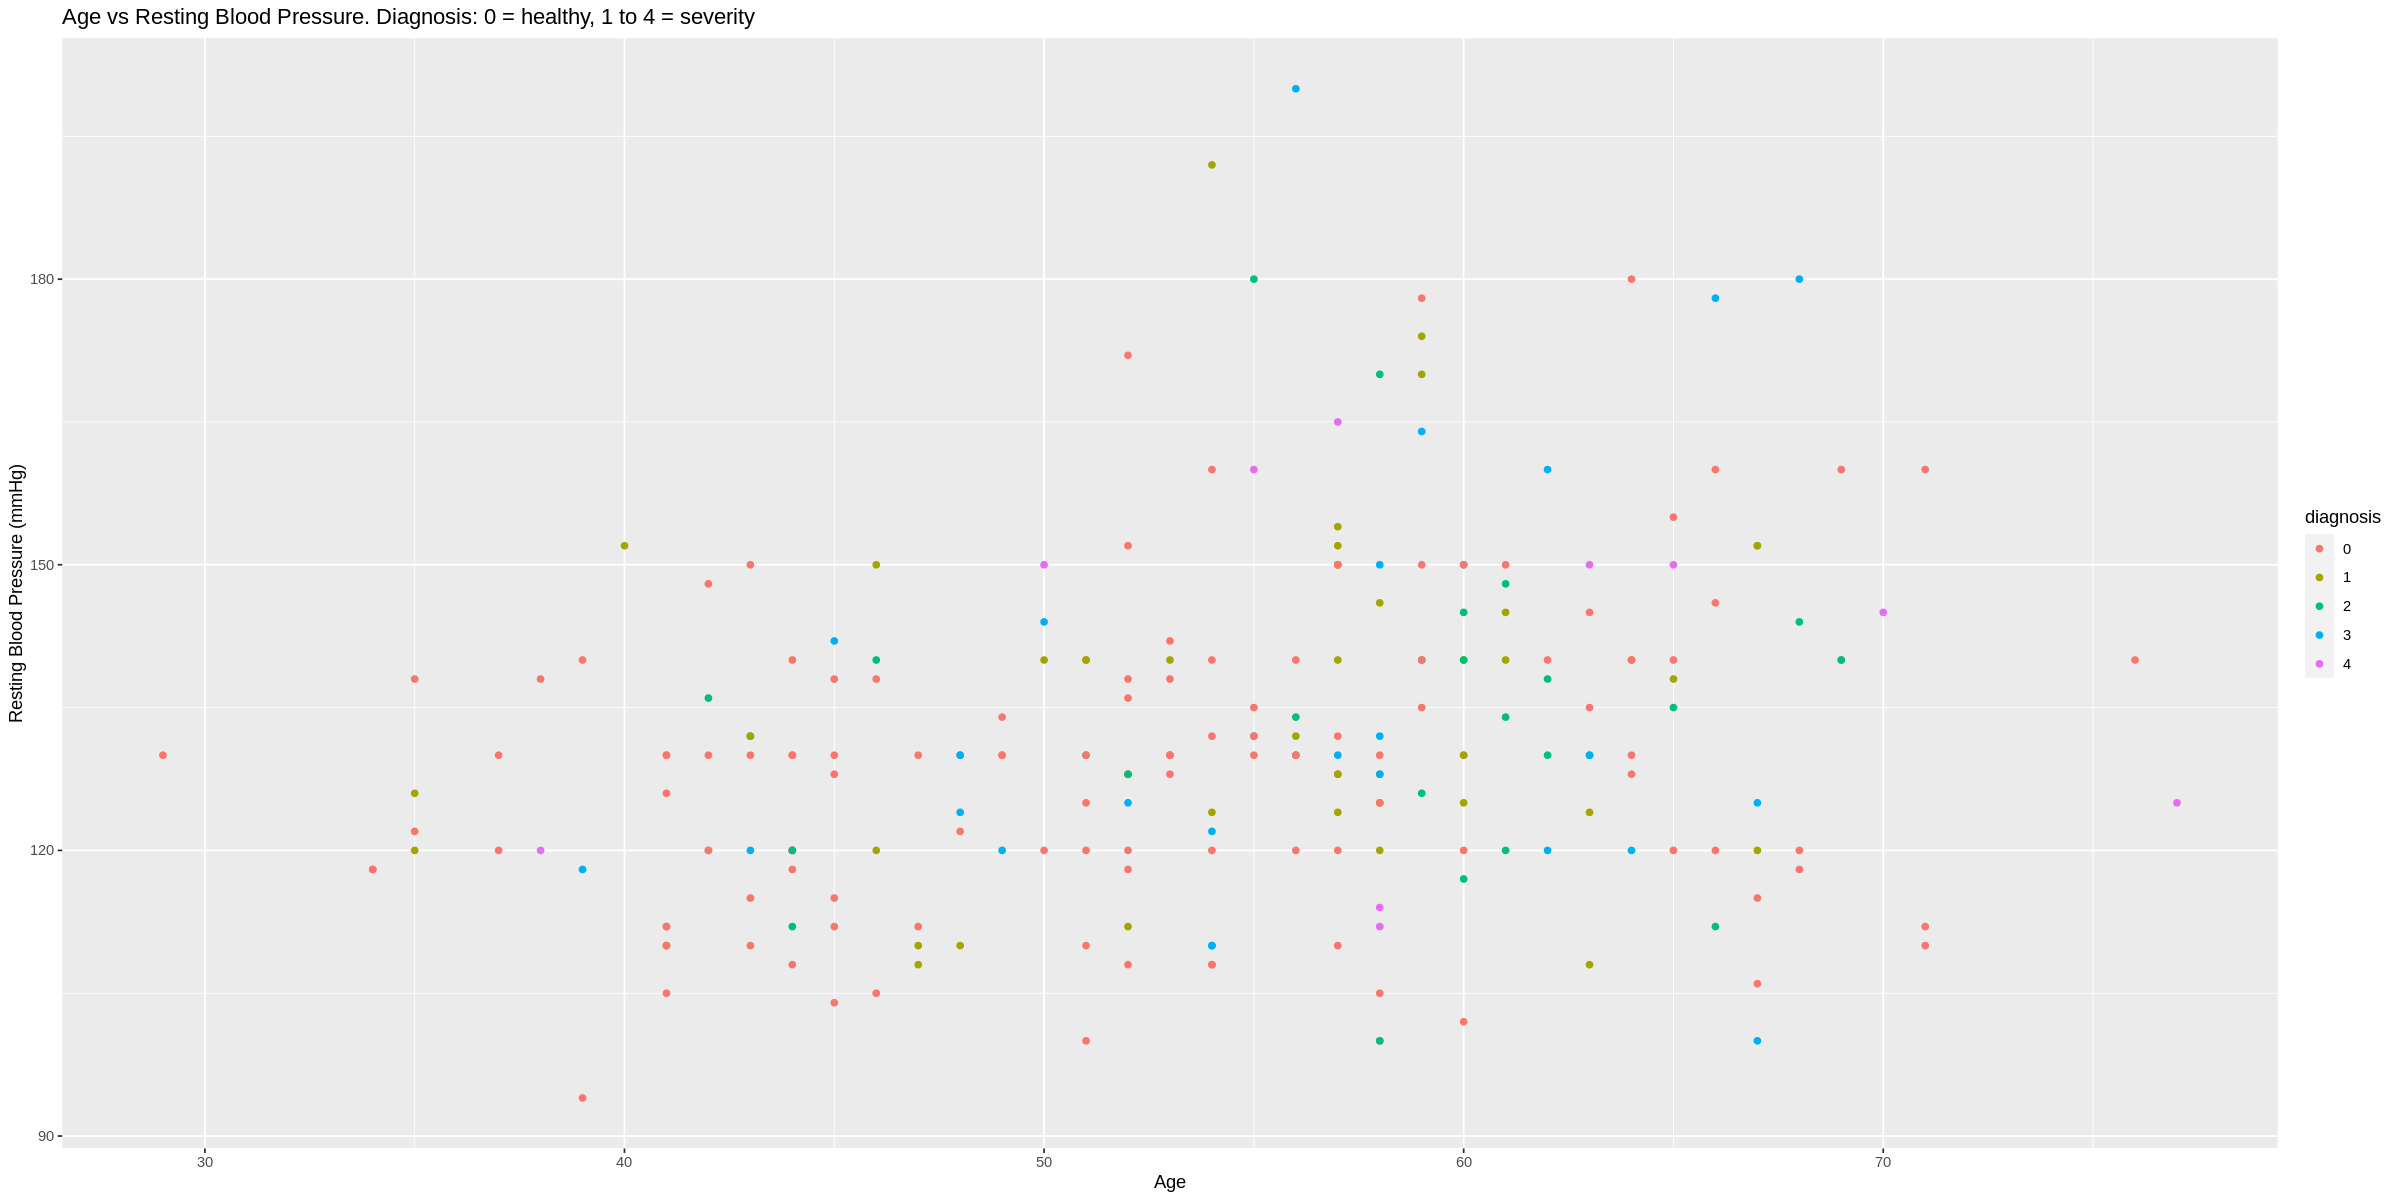

In [87]:
age_vs_resting_bp_plot

Figure 1.                        
Scatterplot of Resting Blood Pressure vs Age. This is to see if there are any noticeable trends in the distribution, or any clear relationship between these variables (which are to be used as predictors), so that we can account for them in the analysis. From this chart, there is no clear correlation between the variables. 

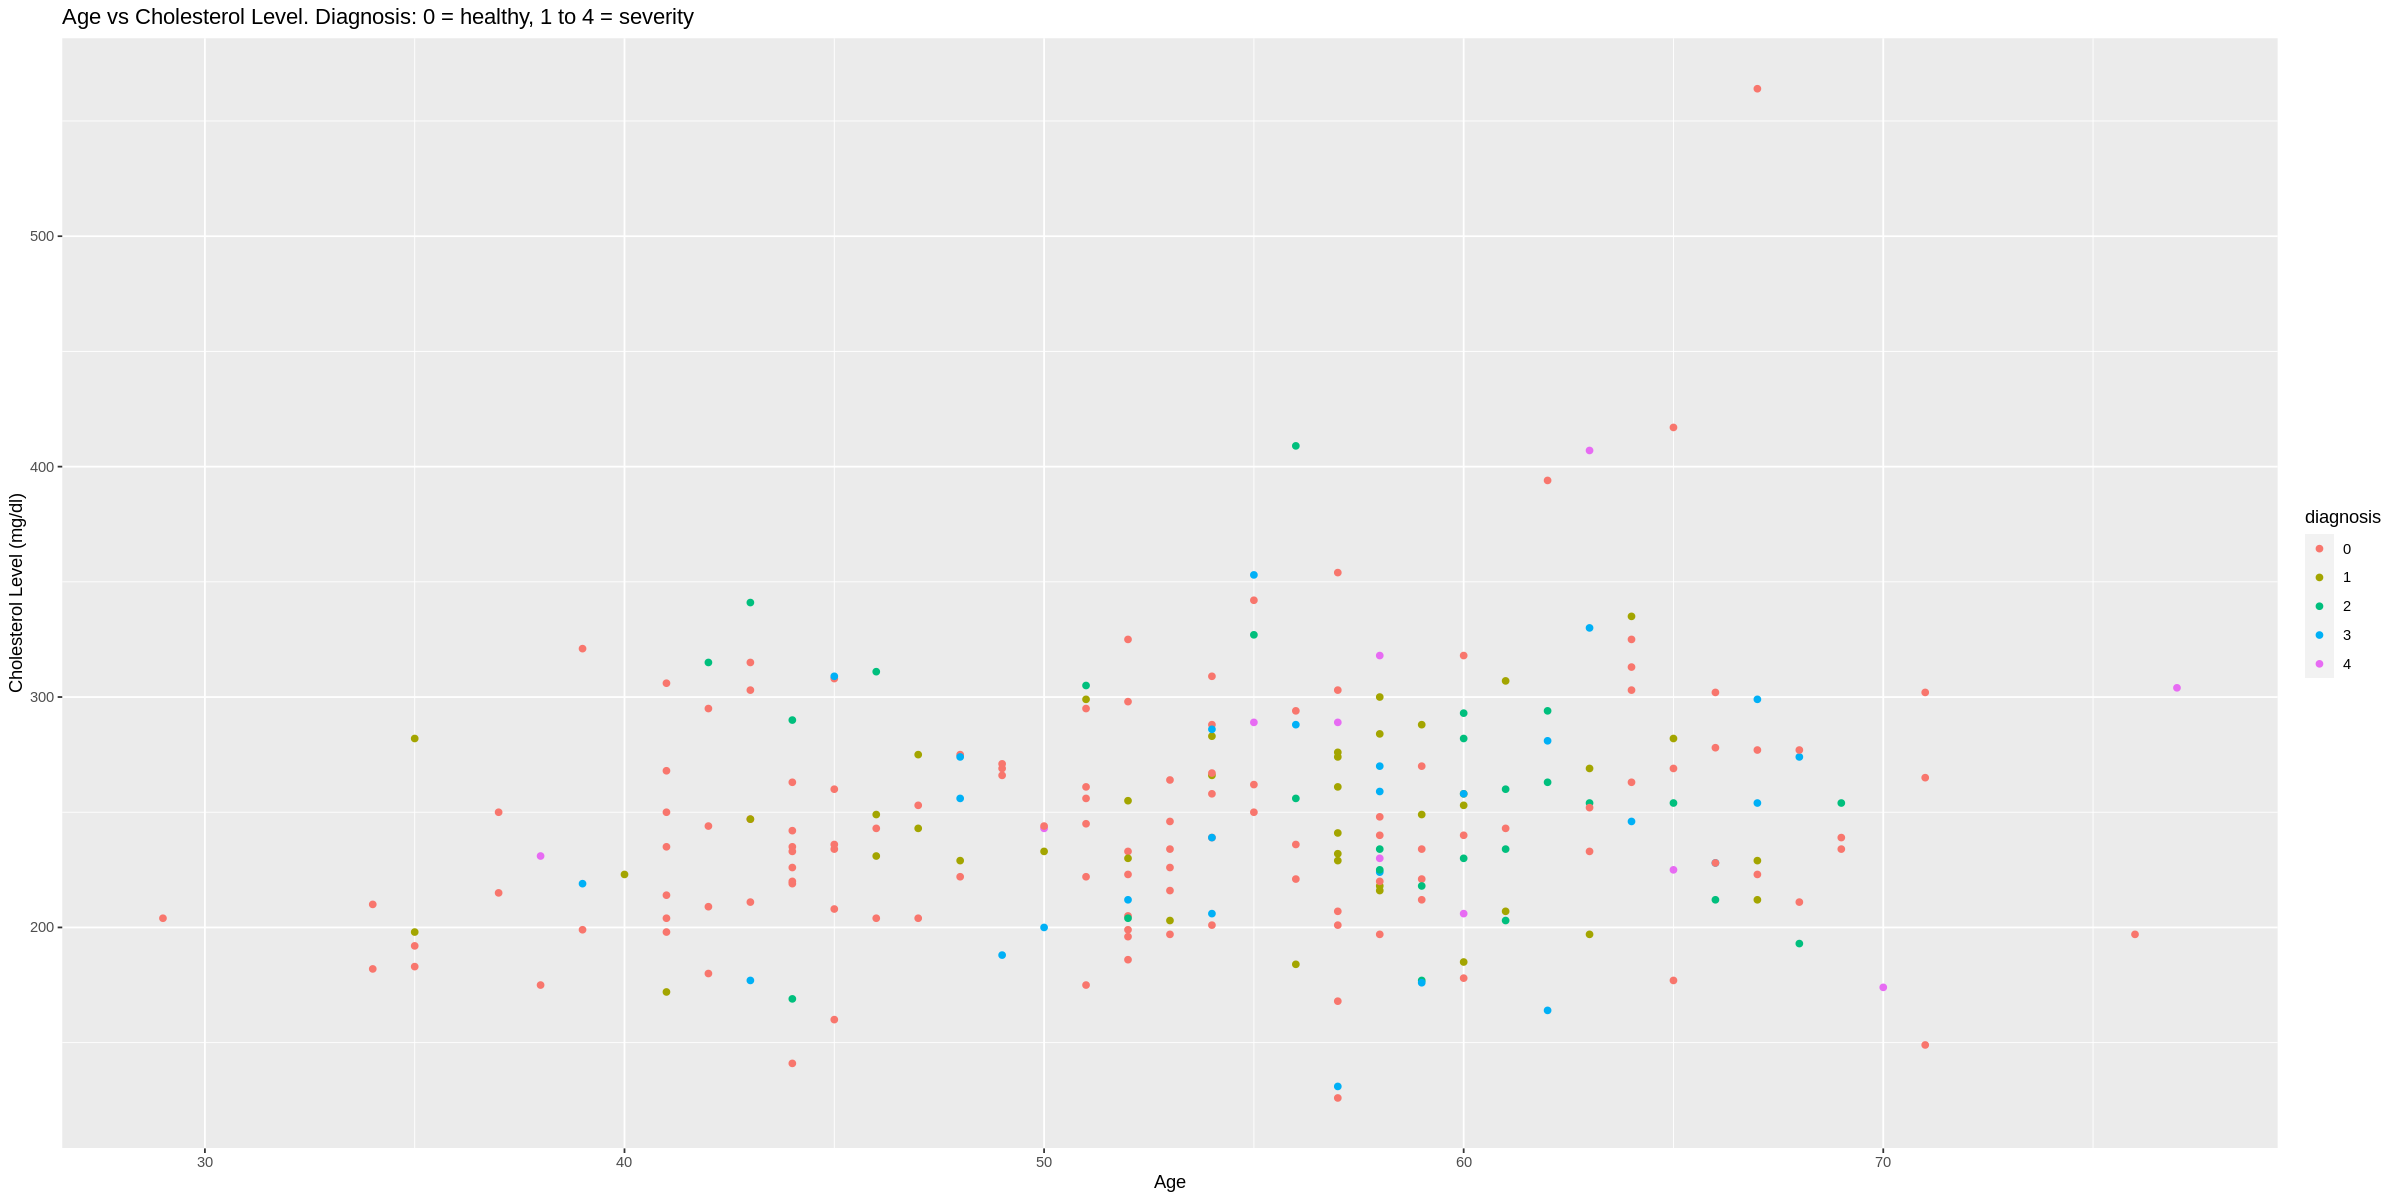

In [88]:
age_vs_cholesterol_plot

Figure 2.                                
Scatterplot of Cholesterol Level vs Age. This is to see if there are any noticeable trends in the distribution, or any clear relationship between these variables (which are to be used as predictors), so that we can account for them in the analysis. From this chart, there is no clear correlation between the variables. 

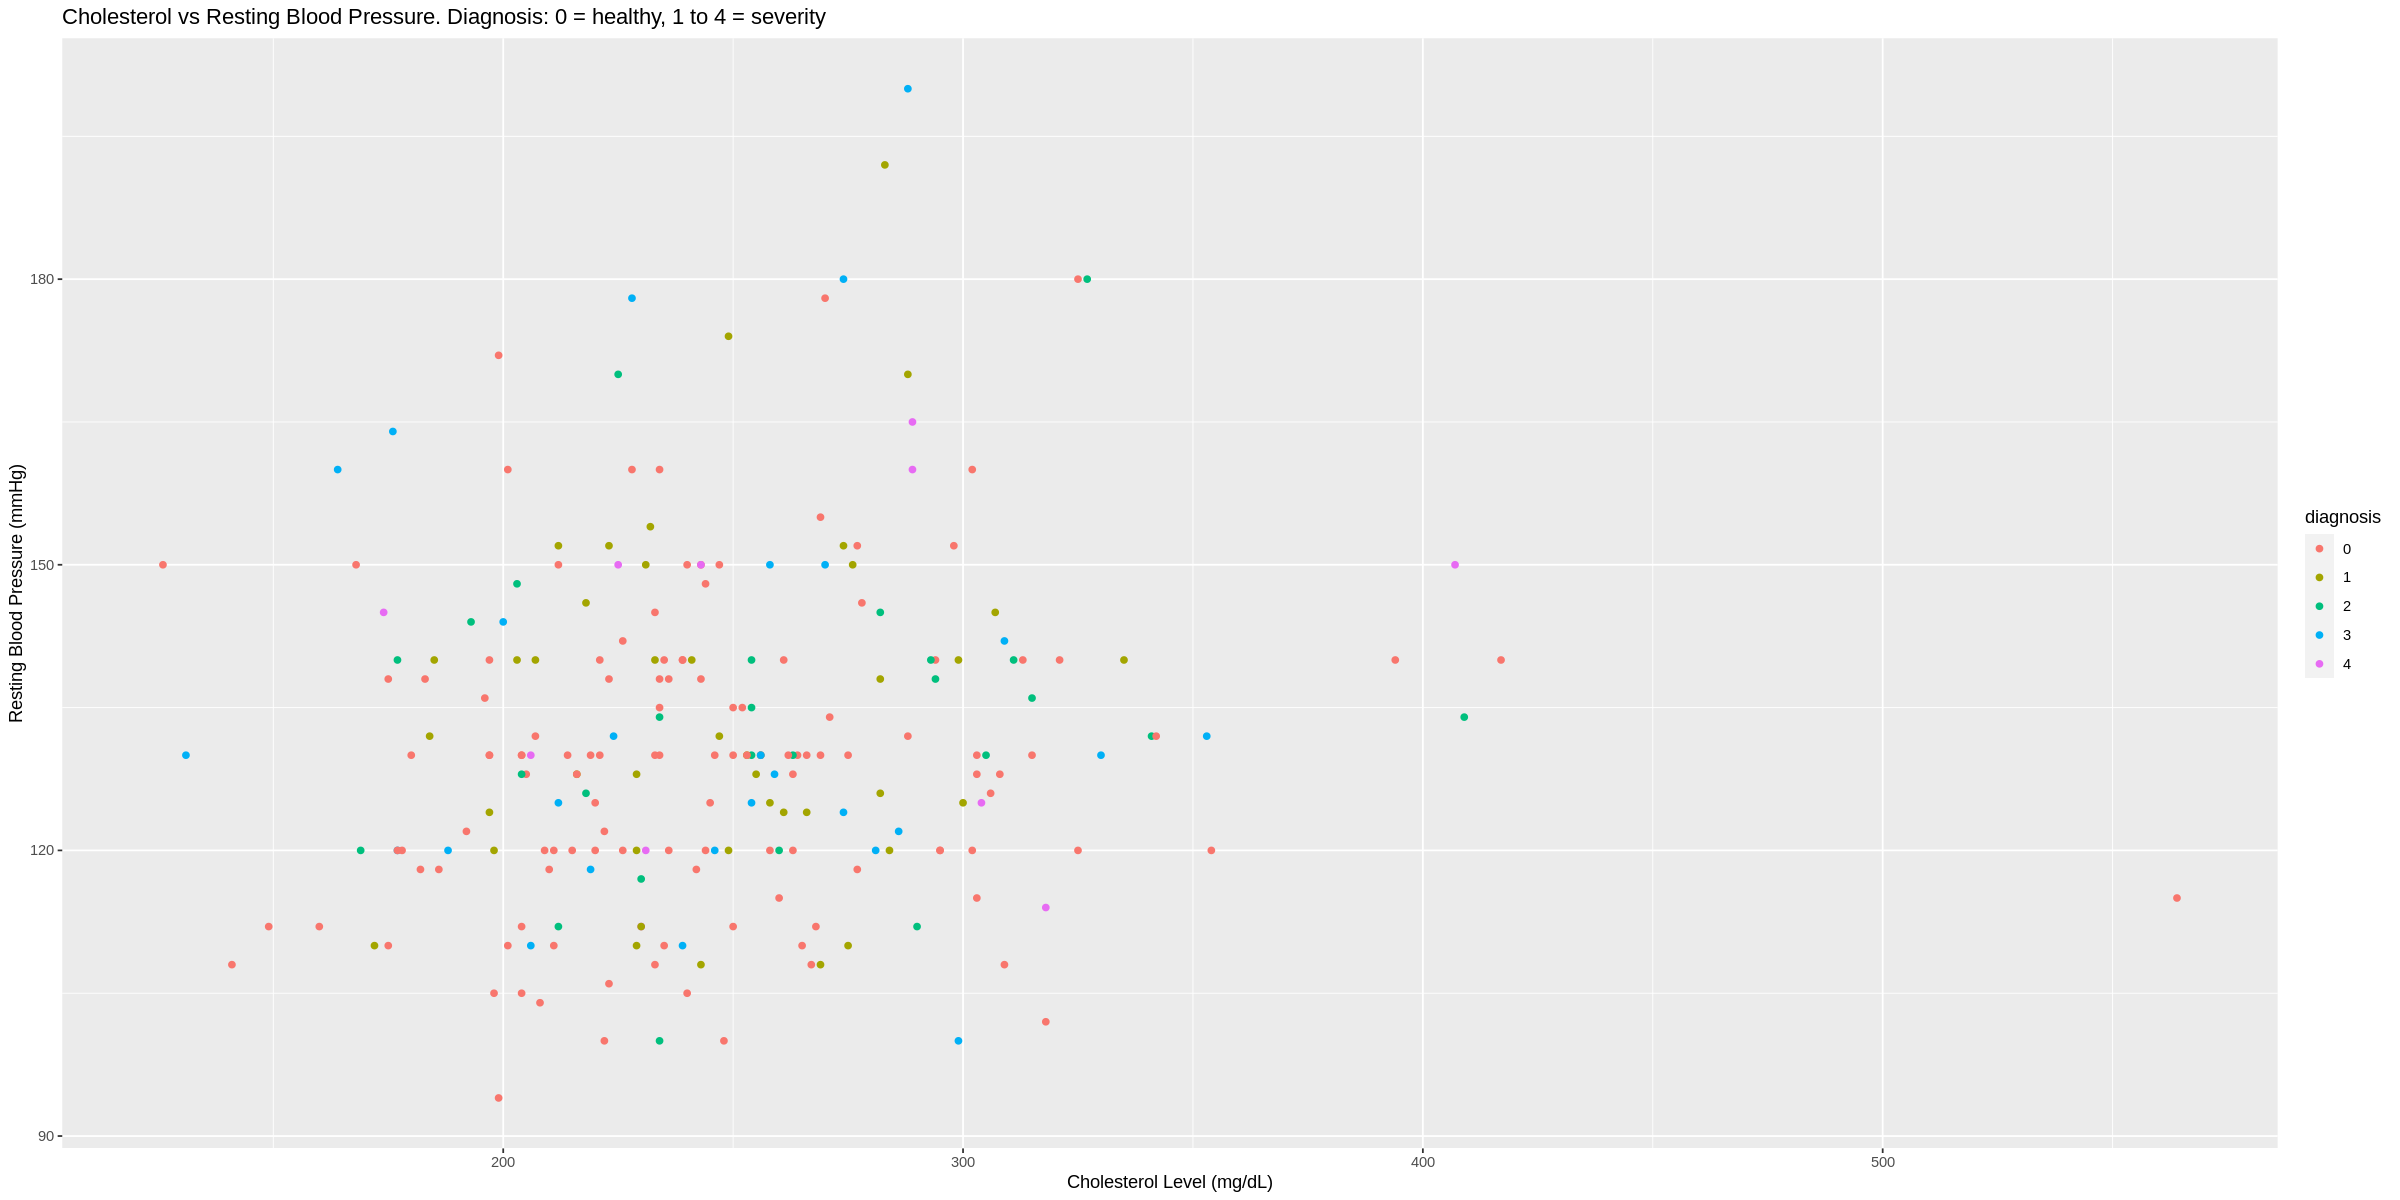

In [89]:
cholesterol_vs_resting_bp_plot

Figure 3.                       
Scatterplot of Resting Blood Pressure vs Cholesterol Level. This is to see if there are any noticeable trends in the distribution, or any clear relationship between these variables (which are to be used as predictors), so that we can account for them in the analysis. From this chart, there is no clear correlation between the variables. 

In [90]:
# trial classification with k = 3 neighbours, accuracy assessment

# recipe:
heart_recipe <- recipe(diagnosis ~. , data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 


# model:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) %>%
       set_engine('kknn') %>%
       set_mode('classification')

# workflow & fit:
heart_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = heart_train)

# predictions:
heart_test_predictions <- predict(heart_fit , heart_test) %>%
       bind_cols(heart_test)

# accuracy assessment (tibble):
heart_prediction_accuracy <- heart_test_predictions %>%
         metrics(truth = diagnosis, estimate = .pred_class) 

# accuracy assessment (confusion matrix):
heart_mat <- heart_test_predictions %>% 
       conf_mat(truth = diagnosis, estimate = .pred_class)

heart_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.37837838
kap,multiclass,0.04058625


Table 4.                             
Accuracy of the model, when using k = 3 neighbours (chosen arbitrarily since this is just an initial trial run to check that it works properly, and to get an idea of the predicted results).

In [91]:
heart_mat

          Truth
Prediction  0  1  2  3  4
         0 22  7  4  6  0
         1  8  3  1  1  1
         2  5  1  1  0  0
         3  3  1  2  1  0
         4  3  2  1  0  1

Table 5.                                  
Confusion matrix of the predictions against the real values. Shows how many of the predictions are correct, and how many are incorrect, in what ways (predicted no disease when there was disease, predicted severe disease when it was less severe, etc.)

In [92]:
# vfold:
heart_vfold <- vfold_cv(heart_train, v = 10, strata = diagnosis)

In [93]:
# cross-validation:
heart_resample_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec) %>%
       fit_resamples(resamples = heart_vfold)

! Fold02: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold03: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold07: internal: No observations were detected in `truth` for level(s): '4'
Com...



In [94]:
#accuracy assessment of the cross-validation:
heart_metrics <- collect_metrics(heart_resample_fit)

In [95]:
# model for tuning:
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine('kknn') %>%
       set_mode('classification')

In [96]:
# gridvals
gridvals <- tibble(neighbors = seq(1,50))

In [97]:
# tuning:
knn_results <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = heart_vfold, grid = gridvals) %>%
       collect_metrics()
knn_results

! Fold02: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold03: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold07: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3929513,10,0.02410113,Model01
1,roc_auc,hand_till,0.5224985,10,0.01667326,Model01
2,accuracy,multiclass,0.3929513,10,0.02410113,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,hand_till,0.5096968,10,0.020445784,Model49
50,accuracy,multiclass,0.5370059,10,0.008622644,Model50
50,roc_auc,hand_till,0.5078514,10,0.018903650,Model50


Table 6.                     
Results from tuning the model with a 10-fold cross-validation. Shows the mean (center) and standard error (spread) of the accuracy expected from each number of neighbours. NOT yet filtered for .metric == 'accuracy'.

In [98]:
# accuracies plot for different values of k:

options(repr.plot.height = 10, repr.plot.width = 20)

accuracies <- knn_results %>% 
       filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.3, 1.0)) # adjusting the y-axis

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3929513,10,0.02410113,Model01
2,accuracy,multiclass,0.3929513,10,0.02410113,Model02
3,accuracy,multiclass,0.4495553,10,0.01111388,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.5370059,10,0.008622644,Model48
49,accuracy,multiclass,0.5370059,10,0.008622644,Model49
50,accuracy,multiclass,0.5370059,10,0.008622644,Model50


Table 7.                                      
Results from the tuning, now filtered so that only the 'accuracy' metrics are left. Will be used to plot estimated accuracy against number of neighbours.

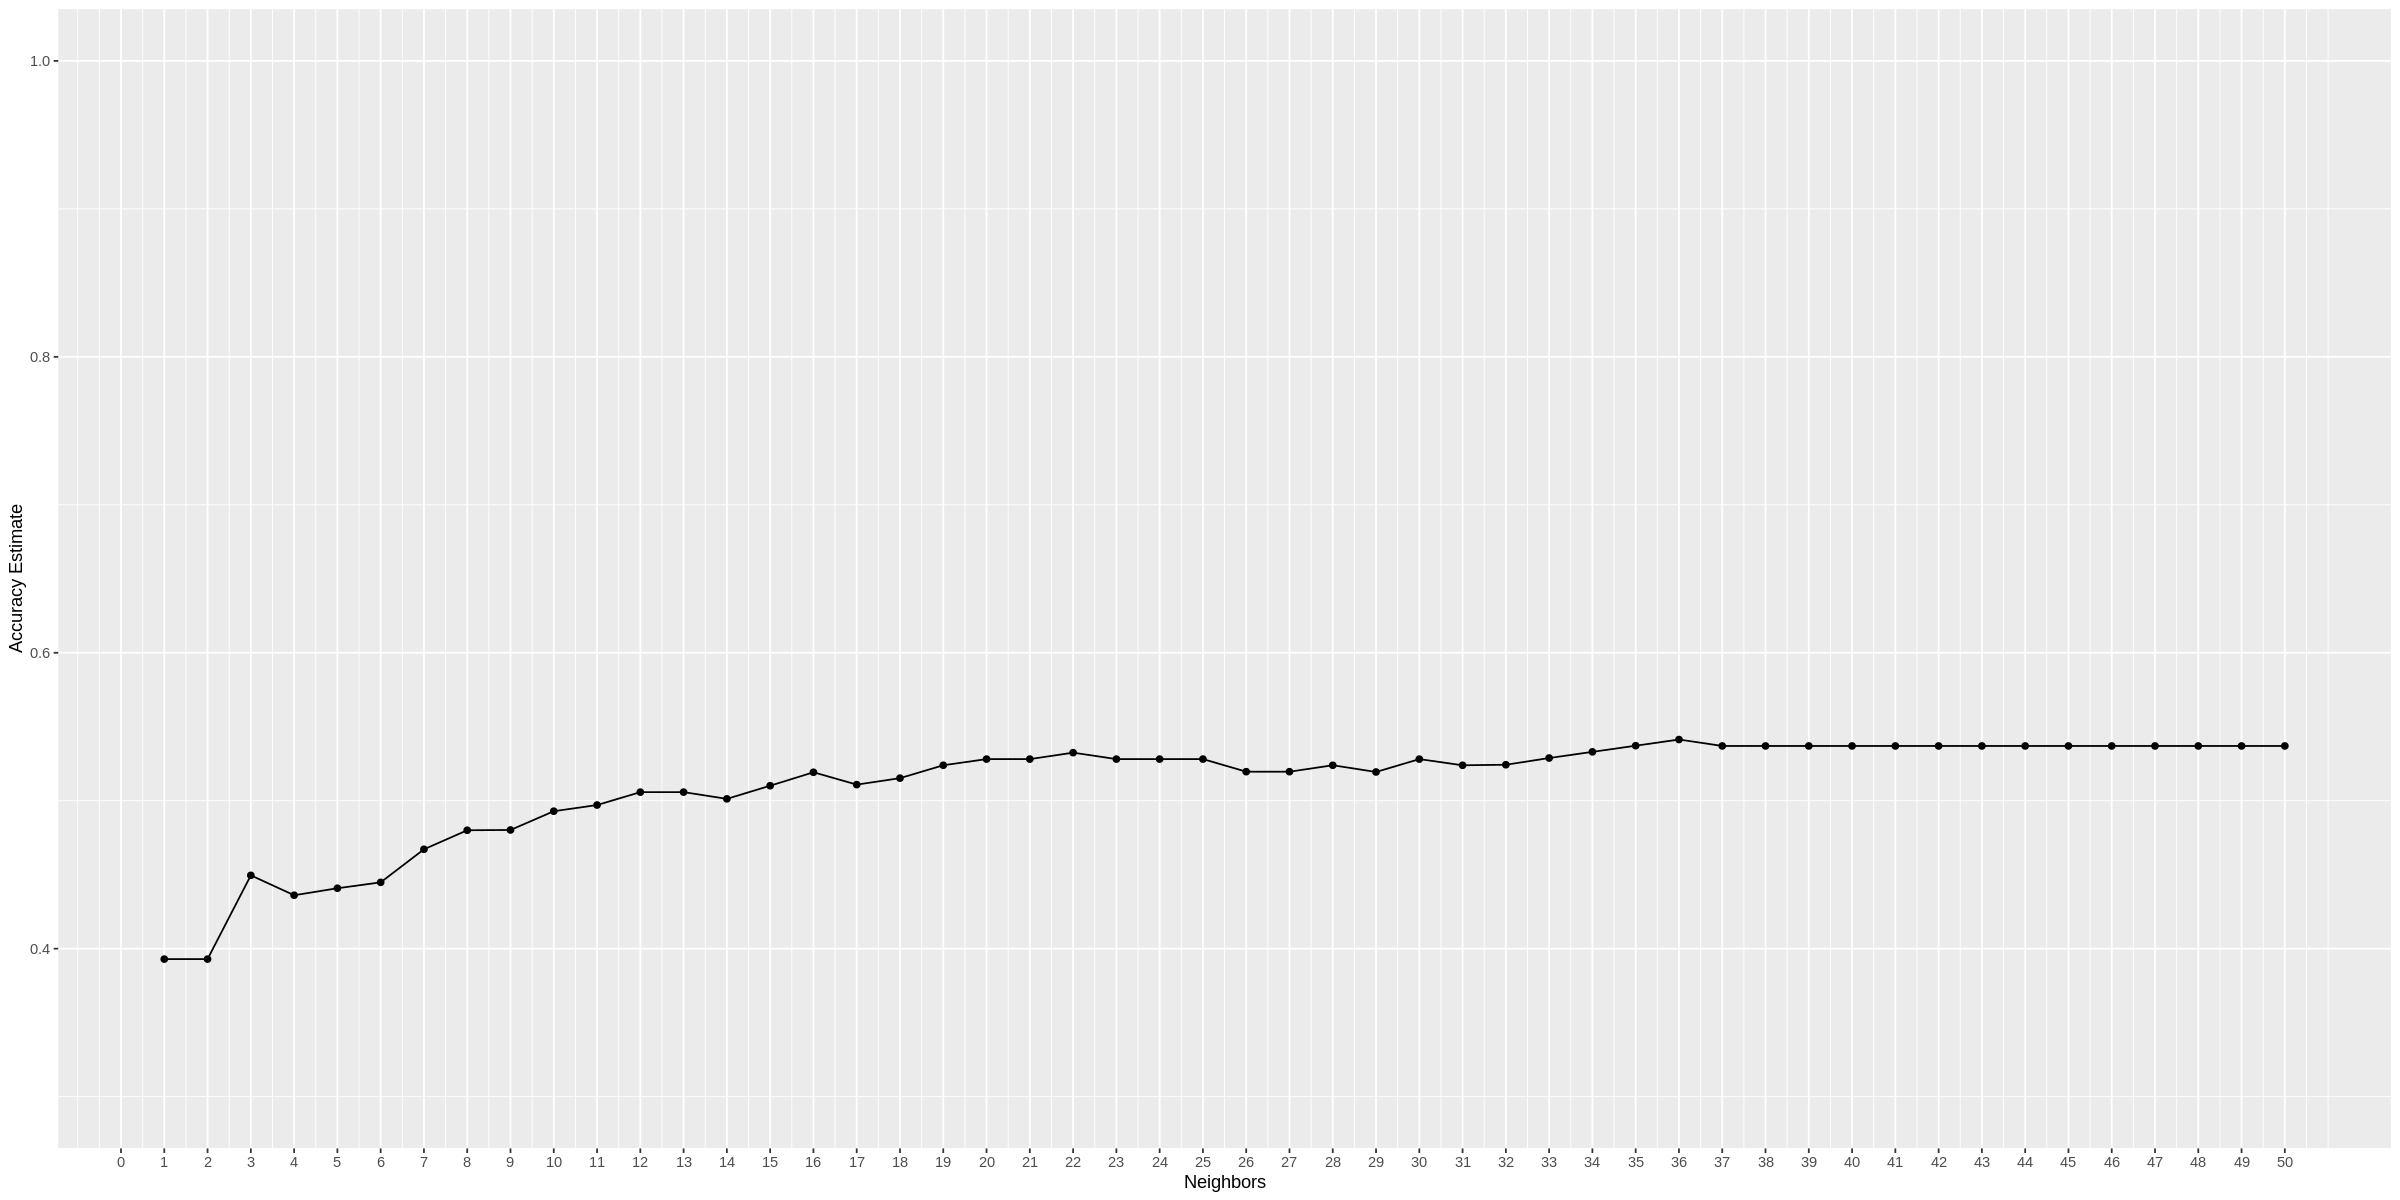

In [99]:
accuracy_versus_k

Figure 4.                                   
Line chart (with data points shown too, as dots), of estimated accuracy vs number of neighbours. This is used to determine the optimum number of neighbours (k value) to use in the final analysis.

This plot shows a gradual increase in accuracy as the neighbours increase, until the peak at 36. Between 37 and 50 (the largest k value tested), the graph levels off. 36 is a number of neighbours that both 1)produces the highest accuracy, and 2)does not have a highly fluctuating accuracy on either side (which means the point is stable enough). Therefore, we choose 36 as the optimum k value to use in the final prediction.

In [100]:
#final classification prediction with 36 neighbours (the optimum k value as shown in the graph above)

# recipe:
heart_recipe 

# model:
knn_spec_final <- nearest_neighbor(weight_func = 'rectangular', neighbors = 36) %>%
       set_engine('kknn') %>%
       set_mode('classification')

# workflow & fit:
heart_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec_final) %>%
       fit(data = heart_train)

# predictions:
heart_test_predictions <- predict(heart_fit , heart_test) %>%
       bind_cols(heart_test)

# accuracy assessment (tibble):
heart_prediction_accuracy <- heart_test_predictions %>%
         metrics(truth = diagnosis, estimate = .pred_class) 

# accuracy assessment (confusion matrix):
heart_mat <- heart_test_predictions %>% 
       conf_mat(truth = diagnosis, estimate = .pred_class)

heart_test_predictions

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

.pred_class,age,resting_blood_pressure,cholesterol_level,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<fct>
0,67,160,286,2
0,62,140,268,3
0,57,140,192,0
⋮,⋮,⋮,⋮,⋮
0,41,120,157,0
0,45,110,264,1
0,57,130,236,1


Table 8.                                 
Predictions of the model (using the previously determined optimum k value) on the testing dataset.

In [101]:
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5540541
kap,multiclass,0.0109356


Table 9.                                       
Accuracy of the final prediction.

In [102]:
heart_mat

          Truth
Prediction  0  1  2  3  4
         0 41 14  8  8  2
         1  0  0  1  0  0
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

Table 10.                             
Confusion matrix showing the distribution of predictions vs actual diagnosis values.

The final prediction using 36 neighbours has an accuracy of 0.5540541 (roughly 55%), when applied to the testing set. Interestingly, the confusion matrix shows that the model predicts all but 1 of the test observations as '0' (no disease), when in reality there are quite a few cases of other values (has disease). This means the model makes a lot of Type 2 errors (failures to predict the presence of the disease).